In [1]:
import scanpy as sc
import scanpy.external as sce

import anndata
from pathlib import Path
from tqdm import tqdm
import pandas as pd

/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/experimental/pytorch/_annloader.py:18: UserWarning: Сould not load pytorch.
  warnings.warn("Сould not load pytorch.")


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from upsetplot import UpSet
from upsetplot import from_contents

In [3]:
#import relation_data_lake as rdl

In [4]:
from scipy import stats

In [5]:
import scipy.sparse as sp
import anndata as ad

In [6]:
import json

import dask.dataframe as dd
import numpy as np
import pandas as pd
#import relation_data_lake as rdl
import scanpy as sc
import scipy.sparse as sp
from anndata import AnnData
#from relation_data_lake.aws.aws_api import pull_folder

In [7]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=400, figsize = [1.5*6.4, 1.5*4.8])
sns.set_style("whitegrid")

In [8]:
n_jobs = 50

sc._settings.ScanpyConfig(
    n_jobs=n_jobs
)

In [9]:
def get_cell_type_proportions_ntc(adata, key):
    tmp = adata[adata.obs.target == 'non-targeting'].obs.copy()
    tmp['Frequency'] = 0
    tmp.Frequency[tmp.condition == 'Il1b'] = 1/tmp[tmp.condition == 'Il1b'].shape[0]
    tmp.Frequency[tmp.condition == 'Resting'] = 1/tmp[tmp.condition == 'Resting'].shape[0]
    tmp.Frequency[tmp.condition == 'Tgfb1'] = 1/tmp[tmp.condition == 'Tgfb1'].shape[0]
    tmp = tmp.groupby([ key, 'condition']).sum()
    tmp = tmp.reset_index()
    tmp.rename(columns={ key: 'Cell Type', 'condition':'Condition'}, inplace=True)
    return tmp

def get_cell_type_proportions_all(adata, key):
    tmp = adata.obs.copy()
    tmp['Frequency'] = 0
    tmp.Frequency[tmp.condition == 'Il1b'] = 1/tmp[tmp.condition == 'Il1b'].shape[0]
    tmp.Frequency[tmp.condition == 'Resting'] = 1/tmp[tmp.condition == 'Resting'].shape[0]
    tmp.Frequency[tmp.condition == 'Tgfb1'] = 1/tmp[tmp.condition == 'Tgfb1'].shape[0]
    tmp = tmp.groupby([ key, 'condition']).sum()
    tmp = tmp.reset_index()
    tmp.rename(columns={ key: 'Cell Type', 'condition':'Condition'}, inplace=True)
    return tmp

In [10]:
def get_cell_type_enrich(adata, key, condition_key):
    
    
    tmp = adata.obs.copy()
    tmp = tmp.groupby(['condition','target',key]).count()
    tmp.reset_index(inplace=True)
    tmp.drop(columns={'n_genes_by_counts','total_counts','total_counts_mt','pct_counts_mt','rep','n_counts','leiden'}, inplace=True)
    tmp.rename(columns={'umap_density_condition':'number_cells'}, inplace=True)

    tmp_R = tmp[tmp.condition == condition_key]
    tmp_R = tmp_R.pivot('target',key, 'number_cells')
    tmp_R = (100*tmp_R.div( tmp_R.sum(axis=1), axis=0) )
    
    tmp_R = tmp_R.div(tmp_R.loc['non-targeting'], axis=1)
    tmp_R.drop(index = 'non-targeting', inplace=True)
    tmp_R = np.log2(tmp_R)
    
    return tmp_R


# Load data and create objects

In [11]:
adata = sc.read_h5ad('/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/Rd13_Data_post_filtering_cell_types-reseq.h5ad.gzip')


In [12]:
adata.write_loom('/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/Rd13_Data_post_filtering_cell_types-reseq.loom', write_obsm_varm=True )

In [13]:
import loompy as lp

In [14]:
f_tfs = "/home/jupyter-jake/SharedData/collaborations/pyscenic/allTFs_mm.txt" 
f_loom_path_scenic = "/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/Rd13_Data_post_filtering_cell_types-reseq.loom"


In [15]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

In [16]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj.csv --num_workers 20

usage: pyscenic grn [-h] [-o OUTPUT] [-t] [-m {genie3,grnboost2}]
                    [--seed SEED] [--num_workers NUM_WORKERS]
                    [--client_or_address CLIENT_OR_ADDRESS]
                    [--cell_id_attribute CELL_ID_ATTRIBUTE]
                    [--gene_attribute GENE_ATTRIBUTE] [--sparse]
                    expression_mtx_fname tfs_fname
pyscenic grn: error: argument tfs_fname: can't open '/home/jupyter-jake/SharedData/collaborations/pyscenic/allTFs_mm.txt': [Errno 2] No such file or directory: '/home/jupyter-jake/SharedData/collaborations/pyscenic/allTFs_mm.txt'


In [17]:
import glob
# ranking databases
f_db_glob = "/home/jupyter-jake/SharedData/collaborations/pyscenic/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/home/jupyter-jake/SharedData/collaborations/pyscenic/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"

In [18]:
!pyscenic ctx adj.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20

usage: pyscenic ctx [-h] [-o OUTPUT] [-n] [--chunk_size CHUNK_SIZE]
                    [--mode {custom_multiprocessing,dask_multiprocessing,dask_cluster}]
                    [-a] [-t] [--rank_threshold RANK_THRESHOLD]
                    [--auc_threshold AUC_THRESHOLD]
                    [--nes_threshold NES_THRESHOLD]
                    [--min_orthologous_identity MIN_ORTHOLOGOUS_IDENTITY]
                    [--max_similarity_fdr MAX_SIMILARITY_FDR]
                    --annotations_fname ANNOTATIONS_FNAME
                    [--num_workers NUM_WORKERS]
                    [--client_or_address CLIENT_OR_ADDRESS]
                    [--thresholds THRESHOLDS [THRESHOLDS ...]]
                    [--top_n_targets TOP_N_TARGETS [TOP_N_TARGETS ...]]
                    [--top_n_regulators TOP_N_REGULATORS [TOP_N_REGULATORS ...]]
                    [--min_genes MIN_GENES]
                    [--expression_mtx_fname EXPRESSION_MTX_FNAME]
                    [--mask_dropouts] [--cell_id

In [19]:
f_pyscenic_output = "pyscenic_output.loom"

In [20]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20


2023-08-09 16:27:54,506 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-08-09 16:27:58,931 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2023-08-09 16:28:00,514 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2023-08-09 16:28:13,368 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


In [21]:
import json
import zlib
import base64

In [22]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [23]:
auc_mtx

,Atf1(+),Atf4(+),Atf6(+),Atf7(+),Bach1(+),Bclaf1(+),Bhlhe40(+),Bhlhe41(+),Bptf(+),Cebpb(+),...,Xbp1(+),Ybx1(+),Yy1(+),Zbtb20(+),Zbtb7a(+),Zfp131(+),Zfp148(+),Zfp37(+),Zfp639(+),Zfx(+)
AAACCCAAGCTTGTGT-Rep5-Resting,0.000000,0.013317,0.0,0.000000,0.004177,0.005771,0.000000,0.006722,0.005497,0.044728,...,0.009383,0.073325,0.012514,0.010148,0.005156,0.0,0.002001,0.011691,0.001798,0.000000
AAACCCACACATGAAA-Rep5-Resting,0.000000,0.025031,0.0,0.000870,0.000278,0.005126,0.007937,0.000000,0.005174,0.031911,...,0.007832,0.070149,0.009410,0.012902,0.007120,0.0,0.003146,0.007194,0.000000,0.000000
AAACCCACATCGCTGG-Rep5-Resting,0.000000,0.018155,0.0,0.000000,0.000500,0.004206,0.000000,0.003468,0.002956,0.044199,...,0.011594,0.071013,0.012511,0.009133,0.003002,0.0,0.002347,0.007140,0.002119,0.000215
AAACGAAAGTTCAACC-Rep5-Resting,0.000000,0.017301,0.0,0.000365,0.010886,0.007131,0.000000,0.004375,0.004989,0.047282,...,0.013889,0.068833,0.015601,0.011318,0.001026,0.0,0.003483,0.010546,0.006998,0.002767
AAACGAACAAAGACTA-Rep5-Resting,0.000000,0.015723,0.0,0.001010,0.000255,0.004154,0.000000,0.000000,0.004065,0.034928,...,0.005805,0.072661,0.013587,0.009111,0.003344,0.0,0.002355,0.008829,0.006356,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCAGACTGGGT-Rep4-Tgfb1,0.009362,0.018487,0.0,0.000000,0.002444,0.003793,0.015512,0.008803,0.002864,0.032880,...,0.015178,0.077153,0.012365,0.008545,0.002698,0.0,0.001812,0.009156,0.000000,0.000000
TTTGGAGCAAAGGGTC-Rep4-Tgfb1,0.000000,0.021507,0.0,0.000000,0.004021,0.005528,0.000000,0.012377,0.001293,0.054682,...,0.013926,0.071651,0.012282,0.006345,0.002939,0.0,0.001112,0.011527,0.003788,0.002472
TTTGTTGAGCAAGCCA-Rep4-Tgfb1,0.000000,0.020211,0.0,0.001094,0.004632,0.004984,0.009921,0.013338,0.003557,0.038495,...,0.015969,0.077446,0.013242,0.009156,0.004143,0.0,0.001622,0.011527,0.007447,0.002821
TTTGTTGTCACAATGC-Rep4-Tgfb1,0.009148,0.018180,0.0,0.000000,0.005021,0.004495,0.038781,0.011790,0.000000,0.036271,...,0.011222,0.079213,0.012282,0.007420,0.001812,0.0,0.001655,0.011663,0.004494,0.000000


In [24]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [25]:
rss_cellType = regulon_specificity_scores( auc_mtx, adata.obs.cell_type )
rss_cellType

,Atf1(+),Atf4(+),Atf6(+),Atf7(+),Bach1(+),Bclaf1(+),Bhlhe40(+),Bhlhe41(+),Bptf(+),Cebpb(+),...,Xbp1(+),Ybx1(+),Yy1(+),Zbtb20(+),Zbtb7a(+),Zfp131(+),Zfp148(+),Zfp37(+),Zfp639(+),Zfx(+)
Inflammatory (injury response),0.331187,0.301494,0.170937,0.296792,0.305240,0.314894,0.172386,0.227988,0.341450,0.330760,...,0.281019,0.299169,0.299702,0.309663,0.350425,0.167873,0.302475,0.311644,0.268163,0.234839
Proliferative,0.194144,0.236528,0.170784,0.248326,0.209634,0.234904,0.176801,0.189388,0.229255,0.229749,...,0.224029,0.233700,0.227141,0.230767,0.230150,0.167445,0.230808,0.230227,0.204305,0.195665
Perturbed fibroblasts,0.232761,0.250525,0.169948,0.229601,0.260882,0.252709,0.247134,0.298811,0.239510,0.241849,...,0.254468,0.248964,0.250317,0.244527,0.237223,0.168891,0.248506,0.253033,0.248909,0.259074
Quiescent,0.297699,0.331278,0.169069,0.250329,0.373186,0.351778,0.184081,0.325151,0.321771,0.362282,...,0.354022,0.346936,0.357965,0.340716,0.316462,0.168544,0.343486,0.341775,0.351286,0.289477
Unknown 2,0.236714,0.217836,0.183137,0.193012,0.217438,0.221771,0.184249,0.206534,0.215046,0.223453,...,0.216005,0.222311,0.232554,0.217231,0.213969,0.173970,0.228698,0.224505,0.223620,0.241337
Unknown 1,0.209224,0.211894,0.169546,0.238934,0.241990,0.221337,0.205115,0.186120,0.201658,0.225361,...,0.208666,0.211000,0.213247,0.210971,0.218190,0.174451,0.217761,0.223288,0.212485,0.216543
Transitory,0.258625,0.310893,0.167808,0.215099,0.277812,0.309765,0.191014,0.278768,0.282539,0.316972,...,0.320980,0.323389,0.322514,0.316505,0.285319,0.167445,0.314247,0.307714,0.312426,0.220974
Lowly activated fibroblasts,0.199036,0.234967,0.171822,0.186208,0.201210,0.223957,0.209222,0.213262,0.215623,0.219404,...,0.229861,0.230933,0.226563,0.235287,0.227389,0.167445,0.232226,0.227087,0.214705,0.187843
Inflammatory & fibrotic,0.207872,0.268150,0.168225,0.234374,0.240051,0.263960,0.185052,0.213758,0.280399,0.259953,...,0.249668,0.261871,0.255694,0.272884,0.277145,0.167445,0.265085,0.268925,0.243046,0.191401
Myofibroblasts,0.285257,0.341361,0.169332,0.221156,0.277627,0.305882,0.466085,0.427975,0.261567,0.291456,...,0.352259,0.328824,0.318538,0.320070,0.281093,0.167445,0.304400,0.314732,0.289055,0.213000


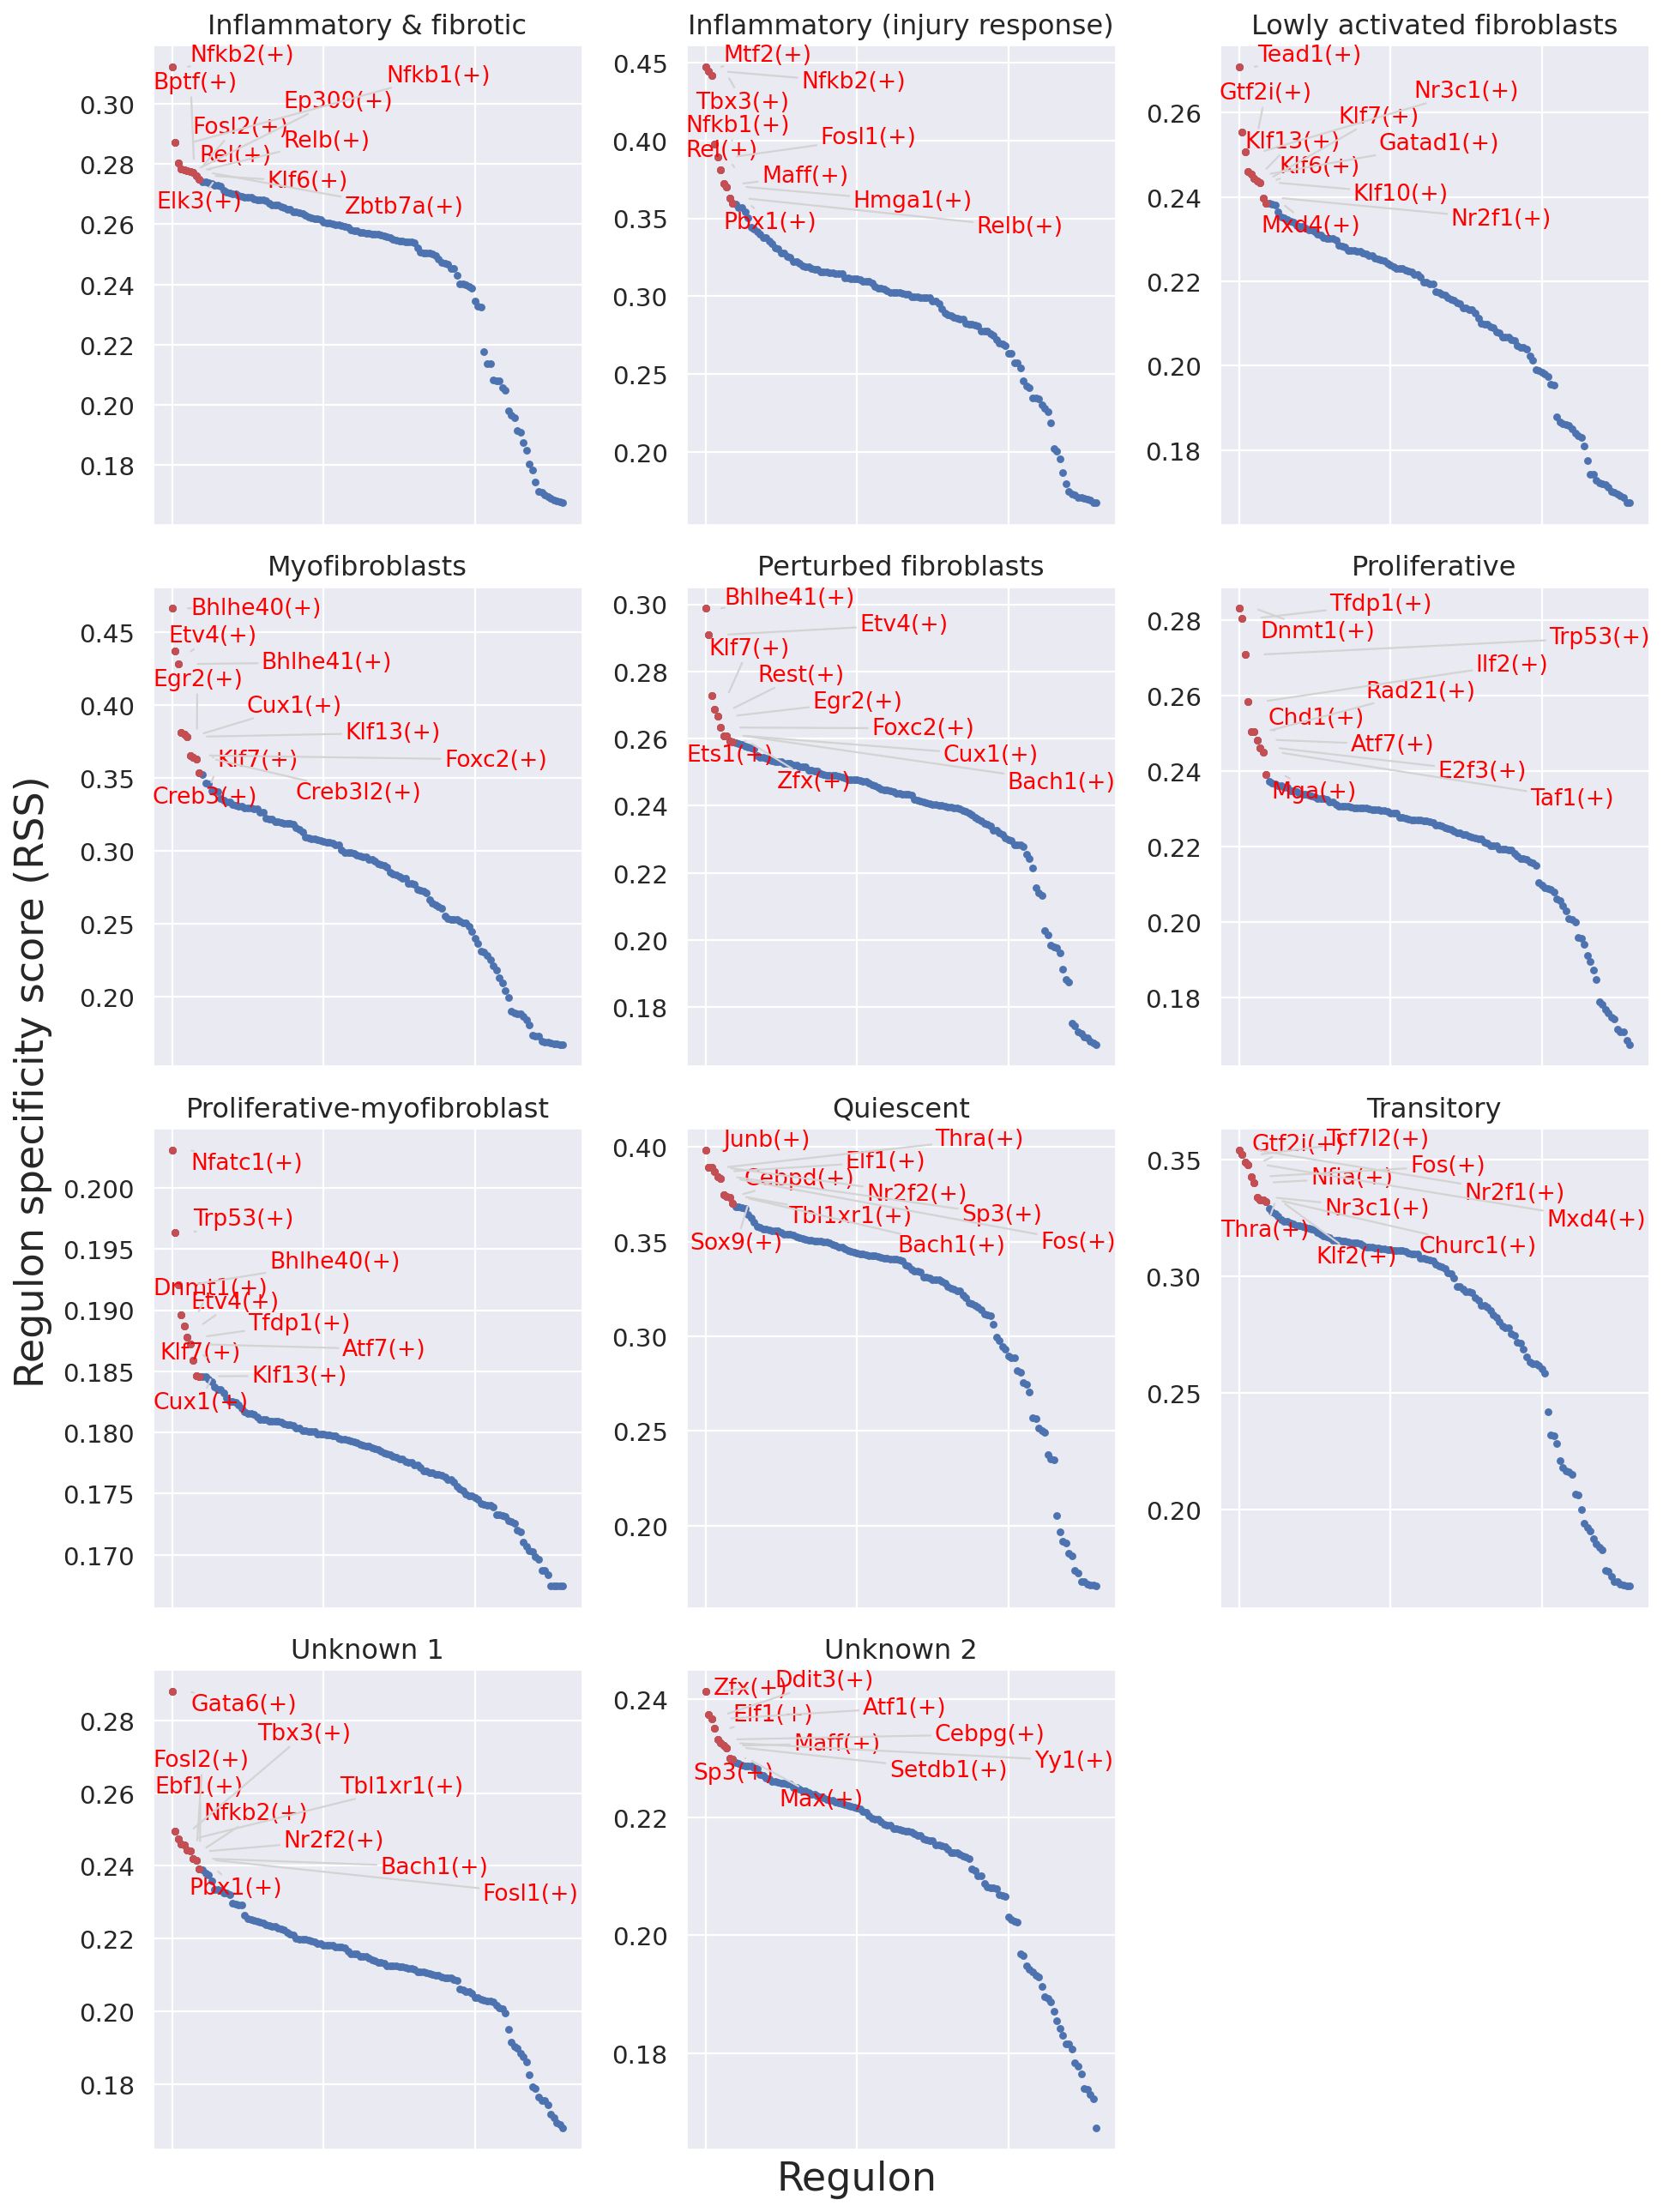

In [33]:
cats = sorted(list(set(adata.obs.cell_type )))

fig = plt.figure(figsize=(12, 16))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(4,3,num)
    plot_rss(rss_cellType, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True, 'figure.titlesize': 'medium' ,'axes.labelsize': 'medium','axes.titlesize':'medium','xtick.labelsize':'medium','ytick.labelsize':'medium'})
plt.savefig("figures/Fibroblast_perturb-seq_cellType-RSS-top10.pdf", dpi=600, bbox_inches = "tight")
plt.savefig("figures/Fibroblast_perturb-seq_cellType-RSS-top10.png", dpi=600, bbox_inches = "tight")
plt.savefig("figures/Fibroblast_perturb-seq_cellType-RSS-top10.svg", dpi=600, bbox_inches = "tight")

plt.show()

In [27]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [28]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

/tmp/ipykernel_2574005/68287874.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/tmp/ipykernel_2574005/68287874.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/tmp/ipykernel_2574005/68287874.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

In [29]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              #cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [30]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in adata.obs.cell_type ]

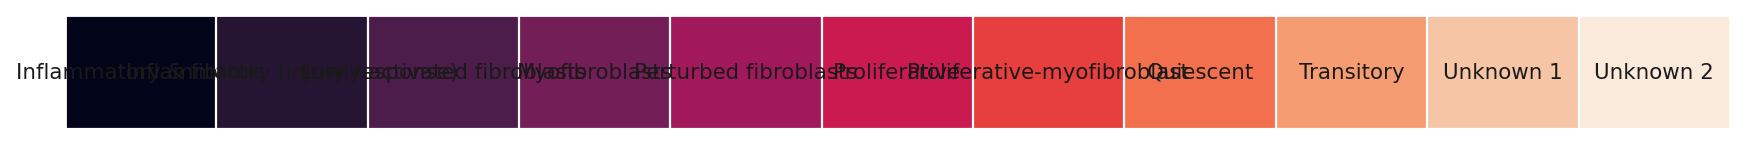

In [31]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("PBMC10k_cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


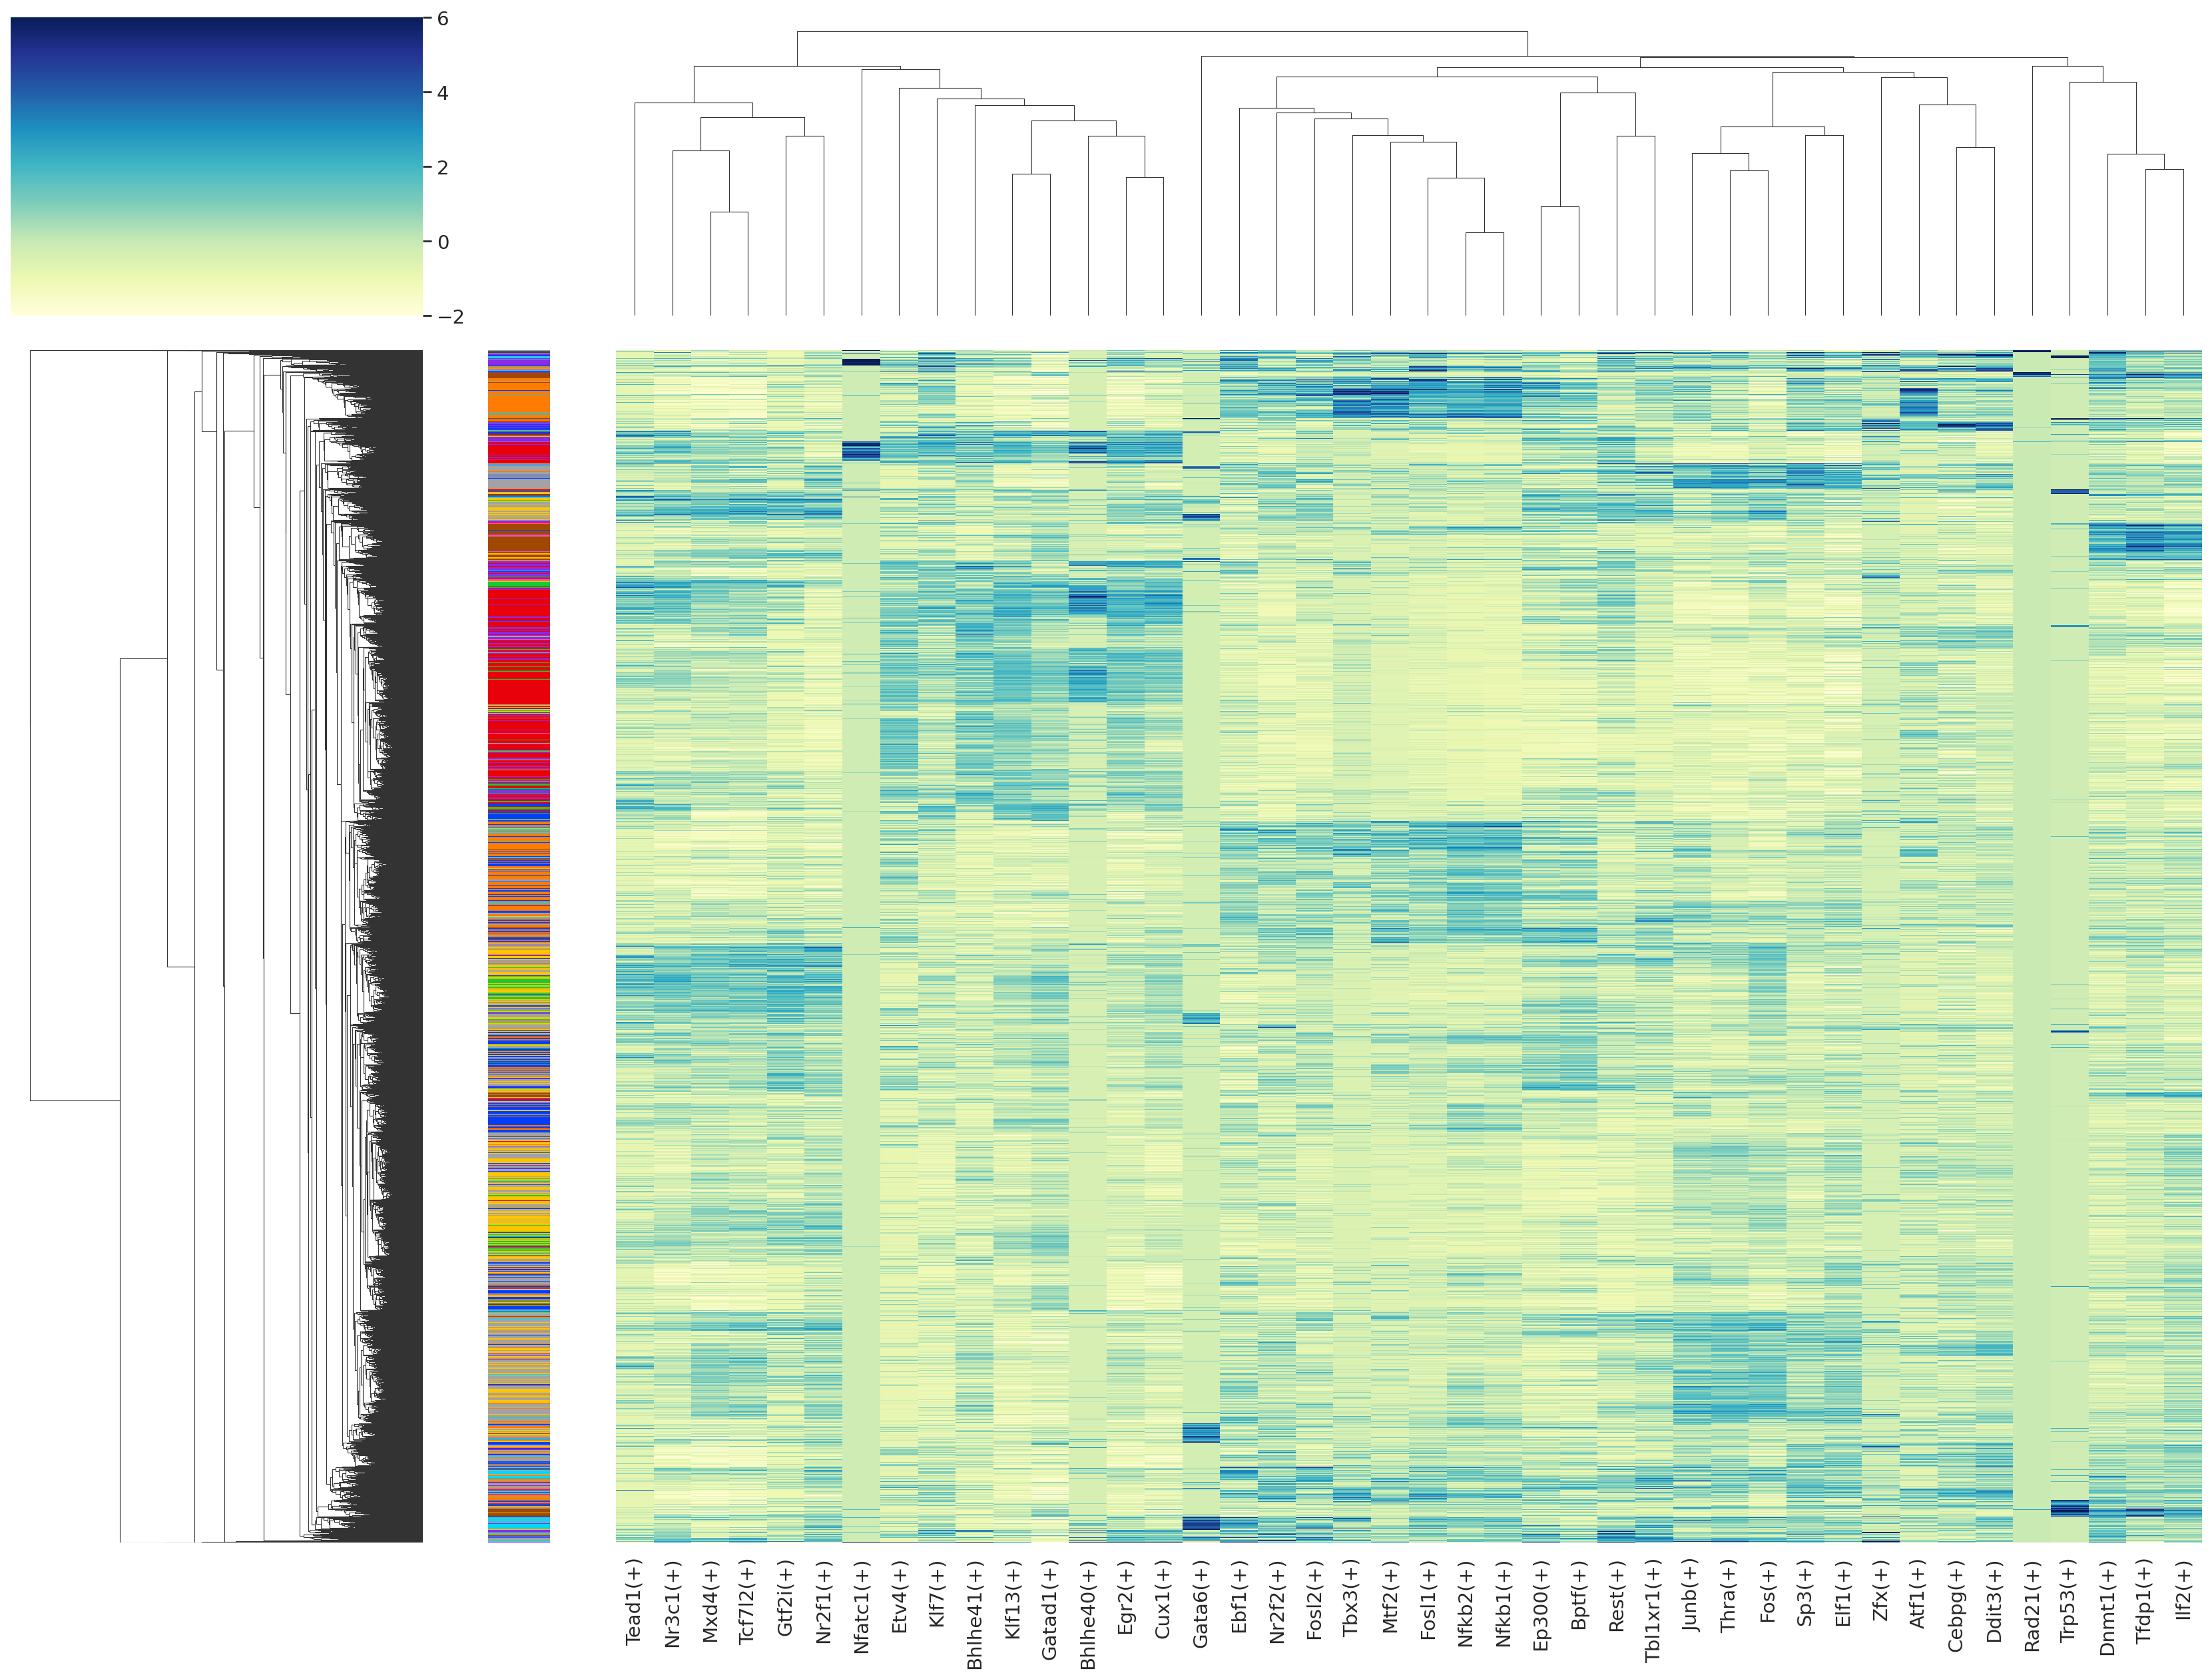

In [32]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("PBMC10k_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")